In [2]:
## Initial setup
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService

import os
from dotenv import load_dotenv

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN)
backend = service.backend(name="ibm_rensselaer")

### Create Uf and Grover's Algorithm Circuit

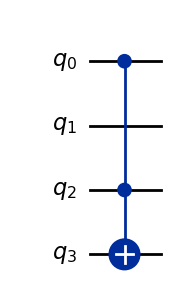

In [11]:
# f(x1, x2, x3) = (x1 OR x2) AND (x1 OR NOT(x2)) AND (NOT(x1) OR x3)
# reduces to f(x1, x2, x3) = x1 AND x3

Uf = qiskit.QuantumCircuit(4)
Uf.ccx(0, 2, 3)
Uf_gate = Uf.to_gate(label='Uf')
Uf.draw(output='mpl')

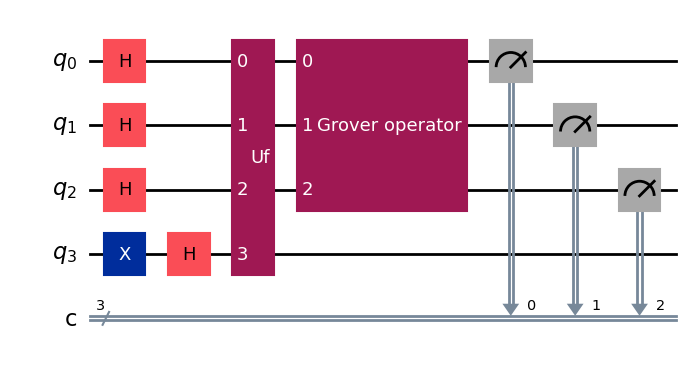

In [17]:
def grover_reflection_operator(n_qubits):
    qc = qiskit.QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    qc.h(n_qubits-1)
    mct = qiskit.circuit.library.standard_gates.XGate().control(n_qubits-1)
    qc.append(mct, range(n_qubits))
    qc.h(n_qubits-1)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    return qc.to_gate(label='Grover operator')

from qiskit.circuit.library import grover_operator

# initial state
qc = qiskit.QuantumCircuit(4, 3)
qc.x(3)
qc.h([0, 1, 2, 3])


## Grover iteration
# run oracle
qc.append(Uf_gate, [0, 1, 2, 3])

# apply grover operator to first three qubits
qc.append(grover_reflection_operator(3), [0, 1, 2])

##

# only measure first three qubits
qc.measure([0, 1, 2], [0, 1, 2])

qc.draw(output='mpl')

In [18]:
# transpile and run
transpiled_grover = qiskit.transpile(qc, backend)
job = backend.run(transpiled_grover, shots=10**4)
result = job.result()
counts = result.get_counts()

/tmp/ipykernel_2975/1912328449.py:3: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_grover, shots=10**4)


In [21]:
counts

{'011': 251,
 '111': 3442,
 '000': 350,
 '001': 270,
 '101': 3037,
 '100': 1301,
 '010': 324,
 '110': 1025}

In [27]:
# Simulation comparison
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
simulator = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=1, backend=simulator)
qc_transpiled = pm.run(qc)

simulation = simulator.run(qc_transpiled, shots=10**4)
simulation_counts = simulation.result()

In [28]:
simulation_counts.get_counts()

{'101': 5051, '111': 4949}

In [29]:
def print_probability_distribution_table(counts, shots=10**4):
    # print start of table
    print("""\\begin{table}[H]
          \\centering
    \\begin{tabular}{|c|c|}
        \\hline
        $x_1$ $x_2$ $x_3$ & $P(x)$ \\\\
        \\hline""")
    for i in range(8):
        binary = format(i, '03b')
        little_endian = binary[::-1]
        frequency = counts.get(little_endian, 0)
        print(f"        {binary} & {frequency/shots} \\\\")

    # print end of table
    print("""        \\hline
    \\end{tabular}
\\end{table}""")

In [30]:
print_probability_distribution_table(counts)

\begin{table}[H]
          \centering
    \begin{tabular}{|c|c|}
        \hline
        $x_1$ $x_2$ $x_3$ & $P(x)$ \\
        \hline
        000 & 0.035 \\
        001 & 0.1301 \\
        010 & 0.0324 \\
        011 & 0.1025 \\
        100 & 0.027 \\
        101 & 0.3037 \\
        110 & 0.0251 \\
        111 & 0.3442 \\
        \hline
    \end{tabular}
\end{table}


In [31]:
print_probability_distribution_table(simulation_counts.get_counts())

\begin{table}[H]
          \centering
    \begin{tabular}{|c|c|}
        \hline
        $x_1$ $x_2$ $x_3$ & $P(x)$ \\
        \hline
        000 & 0.0 \\
        001 & 0.0 \\
        010 & 0.0 \\
        011 & 0.0 \\
        100 & 0.0 \\
        101 & 0.5051 \\
        110 & 0.0 \\
        111 & 0.4949 \\
        \hline
    \end{tabular}
\end{table}
